In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle
from joblib import dump, load

In [2]:
# Loading data set

housings = pd.read_csv('rent_sao_carlos.csv').drop('Unnamed: 0', axis=1)

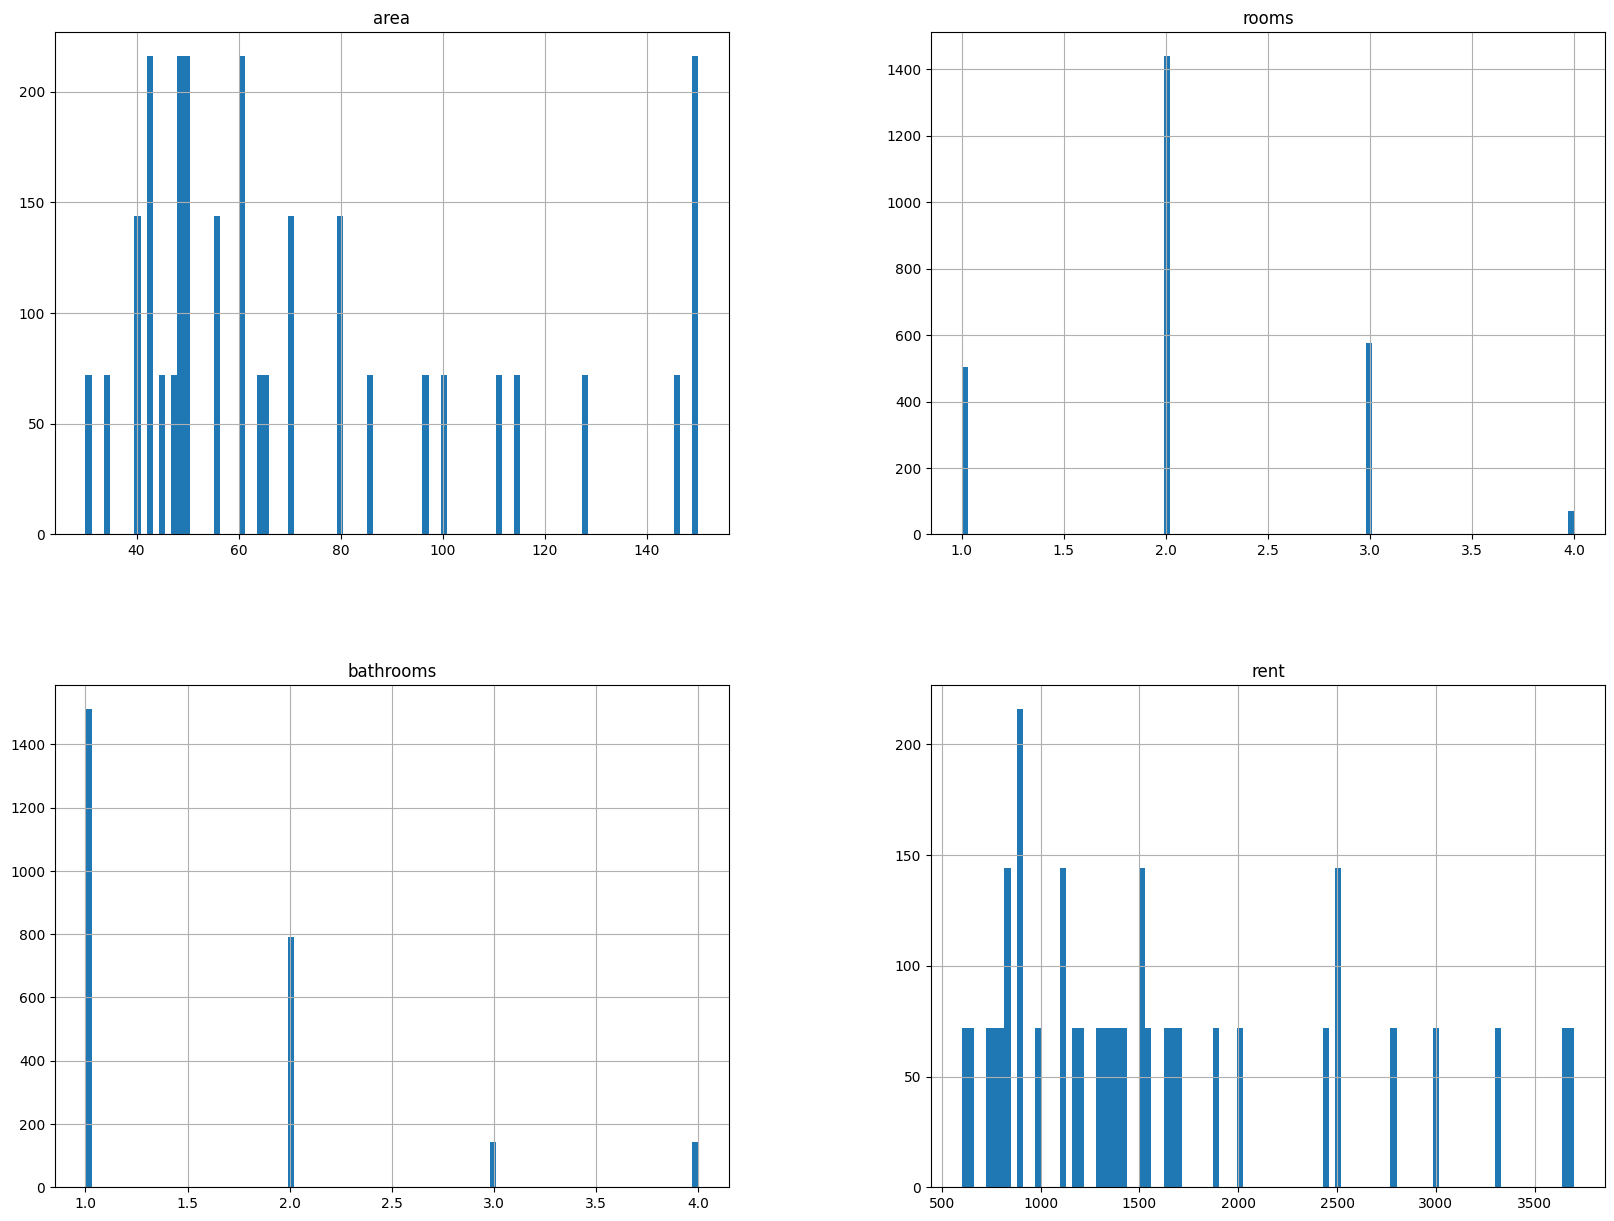

In [3]:
# Getting a first view of the data set

%matplotlib inline
import matplotlib.pyplot as plt
housings.hist(bins=100, figsize=(20,15))
plt.show()

In [4]:
# Get some general information about the dataset

housings.describe()

,area,rooms,bathrooms,rent
count,2592.000000,2592.000000,2592.000000,2592.000000
mean,72.527778,2.083333,1.583333,1600.888889
std,35.460634,0.721827,0.829316,844.954823
min,30.000000,1.000000,1.000000,600.000000
25%,47.750000,2.000000,1.000000,889.000000
50%,60.000000,2.000000,1.000000,1375.000000
75%,88.750000,2.250000,2.000000,1925.000000
max,150.000000,4.000000,4.000000,3700.000000


In [5]:
# Create a test set and a train set

rs = ShuffleSplit(test_size=0.2, random_state=0)
for train_index, test_index in rs.split(housings):
    train_set = housings.loc[train_index]
    test_set = housings.loc[test_index]

In [6]:
# Looking into correlations between area, rooms, bathrooms and rent

corr_matrix = train_set.corr()
corr_matrix['rent'].sort_values(ascending=False)

rent         1.000000
area         0.803401
rooms        0.610482
bathrooms    0.609840
Name: rent, dtype: float64

array([[<AxesSubplot:xlabel='rent', ylabel='rent'>,
        <AxesSubplot:xlabel='area', ylabel='rent'>,
        <AxesSubplot:xlabel='rooms', ylabel='rent'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='rent'>],
       [<AxesSubplot:xlabel='rent', ylabel='area'>,
        <AxesSubplot:xlabel='area', ylabel='area'>,
        <AxesSubplot:xlabel='rooms', ylabel='area'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='area'>],
       [<AxesSubplot:xlabel='rent', ylabel='rooms'>,
        <AxesSubplot:xlabel='area', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='rooms'>],
       [<AxesSubplot:xlabel='rent', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='area', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='bathrooms'>,
        <AxesSubplot:xlabel='bathrooms', ylabel='bathrooms'>]],
      dtype=object)

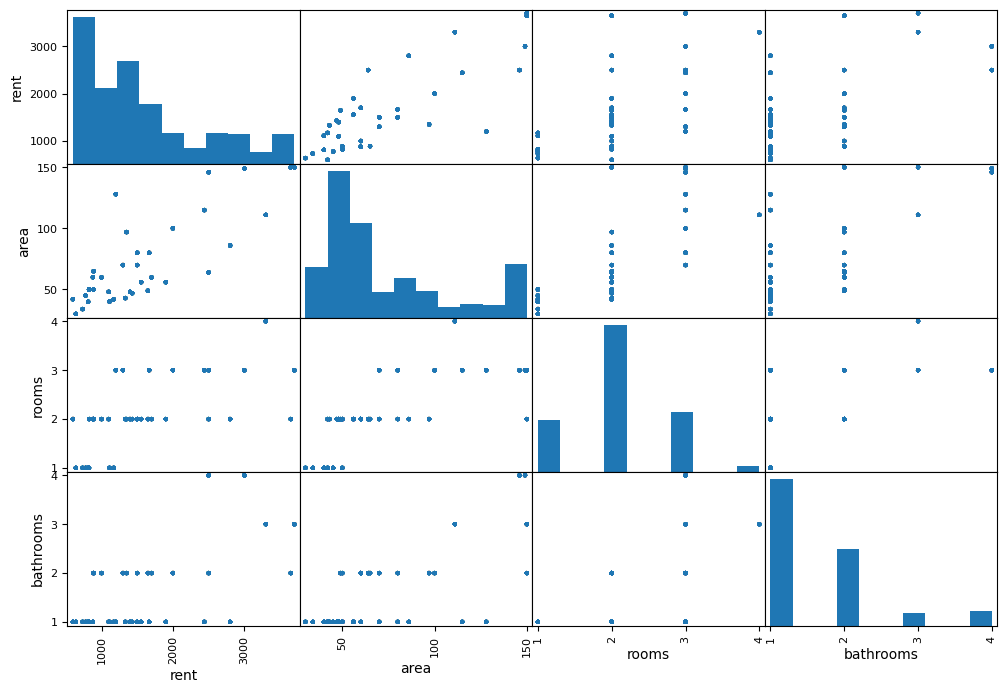

In [7]:
# Looking into the plots, there is only a linear relation between the area and the rent

attributes = ["rent", "area", "rooms",
              "bathrooms"]
pd.plotting.scatter_matrix(train_set[attributes], figsize=(12,8))

In [8]:
# Separating the label from the rest of the data

housings = train_set.drop('rent', axis=1)
labels = train_set['rent'].copy()

In [9]:
# Preparing the data for the training

num_attrs = ['area', 'rooms', 'bathrooms']
cat_attr = ['neighbourhood']
pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', OneHotEncoder(), cat_attr),
])
housing_prep = pipeline.fit_transform(housings)
dump(pipeline, 'pipe.pkl')

['pipe.pkl']

In [10]:
# This function will evaluate the error from an specified training model using the training set

from sklearn.model_selection import cross_val_score

def evaluate_model(model, variables=housing_prep, labels=labels):
    scores = cross_val_score(model, variables, labels,
                            scoring='neg_mean_squared_error', cv=10)
    lin_rmse_scores = np.sqrt(-scores)
    print('Scores:', lin_rmse_scores)
    print('Mean:', lin_rmse_scores.mean())
    print('Std:', lin_rmse_scores.std())

In [11]:
# Below, the training of various regression models

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
evaluate_model(lin_reg)

Scores: [468.6779207  440.05130677 426.39555258 422.65076213 421.00527678
 434.64388101 389.2966774  422.40232517 431.10255249 484.72582063]
Mean: 434.09520756653575
Std: 25.11850569116609


In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
evaluate_model(tree_reg)

Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.0
Std: 0.0


In [13]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
evaluate_model(forest)

Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.0
Std: 0.0


In [14]:
from sklearn.svm import SVR, NuSVR, LinearSVR

svr = SVR()
evaluate_model(svr)

Scores: [866.1753061  785.14168358 733.88198597 761.63904478 698.59753464
 765.60047769 777.76583512 828.25198529 736.18538367 809.13234196]
Mean: 776.2371578798321
Std: 46.59441330781426


In [15]:
nusvr = NuSVR()
evaluate_model(nusvr)

Scores: [870.51793994 792.69069883 735.4170311  763.48064872 702.07478556
 776.56456823 780.57541077 832.72441642 745.59537763 818.06849423]
Mean: 781.7709371430908
Std: 46.9903648643319


In [16]:
linearsvr = LinearSVR()
evaluate_model(linearsvr)

Scores: [814.71090166 760.68200397 678.12114585 687.73520865 705.89767733
 739.76018756 723.22588842 780.99726182 709.97233136 781.76766684]
Mean: 738.2870273480121
Std: 42.79263191497779


In [17]:
# The models that best performed were the decision tree regession and the random forest regression, so I will save them

tree_reg.fit(housing_prep, labels)
forest.fit(housing_prep, labels)

dump(tree_reg, 'tree_reg.pkl')
dump(forest, 'forest.pkl')

['forest.pkl']

In [18]:
# As the decision tree regression is fastest I have choosen it as my model, as the error on the training set was 0, 
# I did not fine tune my model

# When testing on the test set, the final root mean squared error was 0 as well, it seems to be a working model

from sklearn.metrics import mean_squared_error

tree_reg = load('tree_reg.pkl')

x_test = test_set.drop('rent', axis=1)
y_test = test_set['rent'].copy()

x_test_prep = pipeline.transform(x_test)
test_predictions = tree_reg.predict(x_test_prep)
final_mse = mean_squared_error(test_predictions, y_test)
final_rmse = np.sqrt(final_mse)
final_rmse

0.0